In [2]:
import torchvision
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as nnf
import numpy as np
from torchinfo import summary

# Data

In [2]:
# calculate normalization values
trainset = torchvision.datasets.CIFAR10(root='/usr/users/henrich1/repos/exercises_summer_school/data/convnet', train=False, transform=torchvision.transforms.ToTensor())
every_fifth_idx = list(range(0, len(trainset), 5))
trainset = torch.utils.data.Subset(trainset, every_fifth_idx)

num_samples = trainset.dataset.data.shape[0]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples, 
                                            num_workers=2)
imgs, _ = next(iter(trainloader))
dataset_mean = torch.mean(imgs, dim=(0,2,3))
dataset_std = torch.std(imgs, dim=(0,2,3))

normalized_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(dataset_mean, dataset_std)
])

# get train and validation set and dataloaders
trainset = torchvision.datasets.CIFAR10(root='/usr/users/henrich1/repos/exercises_summer_school/data/convnet', train=True, transform=normalized_transform)
every_fifth_idx = list(range(0, len(trainset), 5))
trainset = torch.utils.data.Subset(trainset, every_fifth_idx)
valset = torchvision.datasets.CIFAR10(root='/usr/users/henrich1/repos/exercises_summer_school/data/convnet', train=False, transform=normalized_transform)
every_fifth_idx = list(range(0, len(valset), 5))
valset = torch.utils.data.Subset(valset, every_fifth_idx)

trainloader = DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=1000, shuffle=False, num_workers=2)

In [ ]:
# visualize images from class
classes = trainset.dataset.classes
fig, axs = plt.subplots(1, 10, figsize=(20, 5))

for ax in axs:
    batch = next(iter(trainloader))
    images, labels = batch
    random_idx = torch.randint(0, len(labels), (1,))
    image = images[random_idx].squeeze()
    label = labels[random_idx]

    image = image * dataset_std[:, None, None] + dataset_mean[:, None, None]
    class_name = classes[label]
    ax.set_title(class_name)
    ax.axis('off')
    ax.imshow(image.permute(1,2,0))

# training objects

In [4]:
def train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    min_val_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_one_epoch(model, trainloader, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if epoch % val_interval == 0:
            val_loss, val_accuracy = validate(model, valloader, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

        if savepath_best_statedict is not None:
            if val_loss < min_val_loss:
                torch.save(model.state_dict(), savepath_best_statedict)
                min_val_loss = val_loss
    return train_losses, val_losses, train_accuracies, val_accuracies

def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    total_loss = 0
    total_accuracy = 0
    for x_batch, y_batch in trainloader:
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.squeeze().long().to(device)
        y_pred = model(x_batch)
        pred_class = y_pred.argmax(dim=1)
        accuracy = (pred_class == y_batch).sum() / len(y_batch)

        optimizer.zero_grad()
        loss = nnf.cross_entropy(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += accuracy.item()
    return total_loss / len(trainloader), total_accuracy / len(trainloader)

def validate(model, valloader, device):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.squeeze().long().to(device)
            y_pred = model(x_batch)
            pred_class = y_pred.argmax(dim=1)
            accuracy = (pred_class == y_batch).sum() / len(y_batch)
            
            loss = nnf.cross_entropy(y_pred, y_batch)
            total_loss += loss.item()
            total_accuracy += accuracy.item()
    return total_loss / len(valloader), total_accuracy / len(valloader)

# MLP

In [111]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()

        modules = []
        modules.append(nn.Flatten(start_dim=1))
        for i in range(len(layer_sizes)-1):
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if not i == len(layer_sizes)-2:
                modules.append(nn.ReLU())

        self.layers = nn.Sequential(*modules)


    def forward(self, x):
        return self.layers(x)

In [113]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# model = MLP([3*32*32, 32, 64, 32, 10]).to(device)
model = MLP([3*32*32, 32, 32, 10]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
epochs = 10
val_interval = 1

train_losses, val_losses, train_accuracies, val_accuracies = train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None)

cuda


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


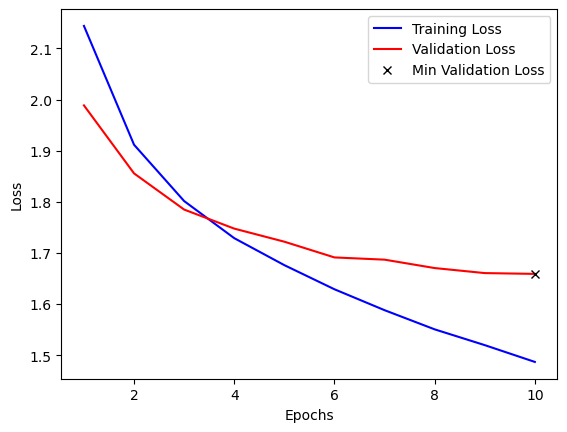

In [114]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_losses, c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), val_losses, c='red', label='Validation Loss')

# Mark the minimum validation loss
index = np.argmin(val_losses)
plt.plot(index+1, val_losses[index], 'kx', label='Min Validation Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


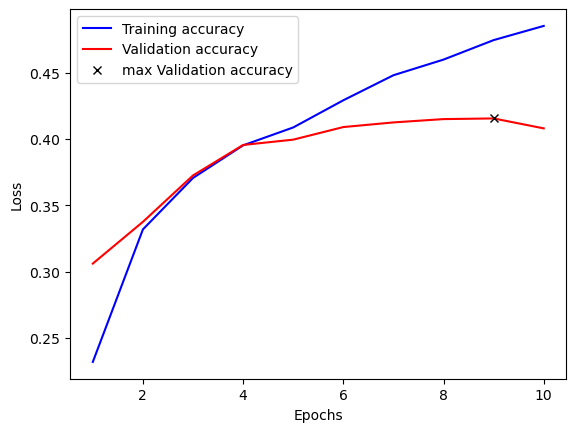

In [115]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_accuracies, c='blue', label='Training accuracy')
plt.plot(np.linspace(1, epochs, epochs), val_accuracies, c='red', label='Validation accuracy')

# Mark the minimum validation loss
index = np.argmax(val_accuracies)
plt.plot(index+1, val_accuracies[index], 'kx', label='max Validation accuracy')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# CONVNET

In [35]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding='valid')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='valid')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding='valid')
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='valid')
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)
        self.bn6 = nn.BatchNorm2d(64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(64, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nnf.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nnf.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = nnf.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = nnf.relu(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = nnf.relu(x)
        # x = self.conv6(x)
        # x = self.bn6(x)
        # x = nnf.relu(x)
        x = self.avgpool(x)
        x = self.linear(x.squeeze())

        return x

In [ ]:
model = ConvNet()
summary(model, input_size=(1000, 3, 32, 32))

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = ConvNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
epochs = 20
val_interval = 1

train_losses, val_losses, train_accuracies, val_accuracies = train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None)

cuda


100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


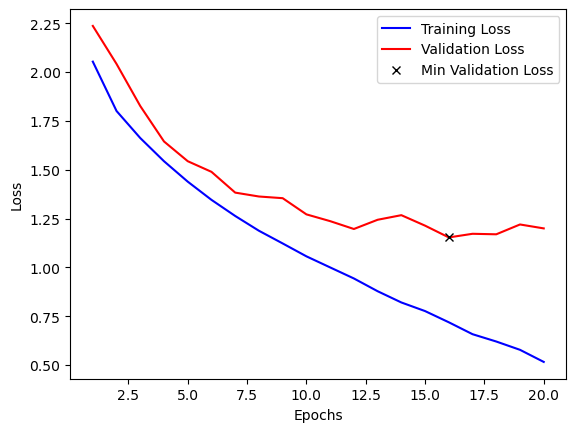

In [38]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_losses, c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), val_losses, c='red', label='Validation Loss')

# Mark the minimum validation loss
index = np.argmin(val_losses)
plt.plot(index+1, val_losses[index], 'kx', label='Min Validation Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

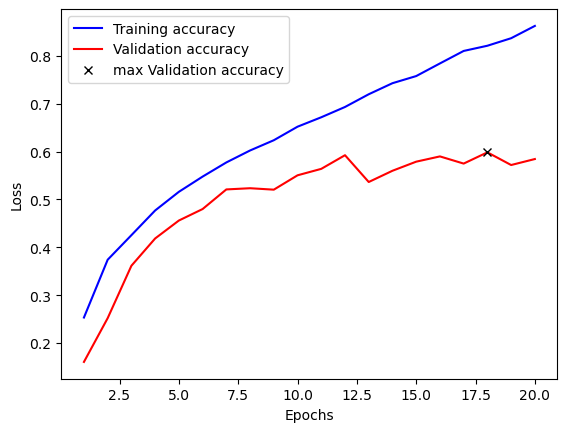

In [39]:

####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_accuracies, c='blue', label='Training accuracy')
plt.plot(np.linspace(1, epochs, epochs), val_accuracies, c='red', label='Validation accuracy')

# Mark the minimum validation loss
index = np.argmax(val_accuracies)
plt.plot(index+1, val_accuracies[index], 'kx', label='max Validation accuracy')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# experiment results

In [29]:
import pandas as pd
test = pd.read_pickle('/usr/users/henrich1/repos/exercises_summer_school/exercises/convnet/experimental_results.pkl')
# test.iloc[test['min_val_loss'].argmin(), :]
test[test['layer_sizes'].apply(lambda x: x == [3072, 384, 384, 384, 10])]
print(test[test['dropout_ratio'].apply(lambda x: x == 0)]['max_val_acc'].max())
print(test[test['dropout_ratio'].apply(lambda x: x == 0.1)]['max_val_acc'].max())
print(test[test['dropout_ratio'].apply(lambda x: x == 0.3)]['max_val_acc'].max())
print(test[test['dropout_ratio'].apply(lambda x: x == 0.6)]['max_val_acc'].max())

0.47450003027915955
0.4905000180006027
0.5000000298023224
0.4910000264644623


In [21]:
test['max_val_acc'].argmax()

59

In [22]:
test.iloc[59]

dropout_ratio                                                     0.3
weight_decay                                                     0.01
layer_sizes                                 [3072, 384, 384, 384, 10]
min_val_loss                                                 1.501346
max_val_acc                                                     0.497
train_losses        [2.079287588596344, 1.8507863759994507, 1.7486...
val_losses          [1.8579891920089722, 1.7426167726516724, 1.674...
train_accuracies    [0.22840001434087753, 0.3337000161409378, 0.36...
val_accuracies      [0.3400000184774399, 0.37300002574920654, 0.41...
Name: 59, dtype: object